In [356]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Packages to modify data to prepare for machine learning model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils import shuffle

#Packages for Accuracy testing
from sklearn.metrics import classification_report, plot_confusion_matrix, roc_auc_score, roc_curve, accuracy_score

#Packages for Logistic Regression
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

#Packages for Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

#Packages for XGBoost
import xgboost as xgb

#Packages for Keras
from keras.models import Sequential
from keras.layers import Dense, Flatten

#Packages for PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# Introduction

For the data wrangling, it was fairly standard code. The biggest thing done here is using the SMOTE package to help reverse the large imbalance in the dataset. This dataset was found in Kaggle. It contains information regarding the financial information of Taiwanese companies, and the data was collected from the Taiwan Economic Journal. The variable I am trying to predict is Bankruptcy. In other words, using all of the given variables and predicting whether or not a company will go bankrupt. In total, there are 95 variables that can be helpful in predicting the bankruptcy variable, along with over 6800 rows.

# Data Wrangling--------------------------------------------------------------------

For the data wrangling, it was fairly standard code. The biggest thing done here is using the SMOTE package to help reverse the large imbalance in the dataset. The second chunk highlights the correlation of the variables to the Bankruptcy variable. As you can see, the dataset is not the ideal dataset since there is little correlation. By the time I saw this issue, I had already spent quite a bit of time getting to know the dataset and made most of the models as well. I couldn't find a better dataset and make new models within the time I had left.

In [357]:
df = pd.read_csv('Bankruptcy_Prediction_data.csv')
X=df.copy()

Y=X.pop('Bankrupt?')

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3,random_state=70)

scaler = preprocessing.StandardScaler()
x_train= scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
smote = SMOTE()
x_trainSM, y_trainSM = smote.fit_resample(x_train, y_train)


In [377]:
correlation=df.corr()['Bankrupt?']
top_corr=(correlation[abs(correlation)<.5].sort_values(ascending=False)[0:40])
low10=((correlation[abs(correlation)<.5].sort_values(ascending=False)[-40:]))
top_corr=pd.concat([top_corr, low10])
print(top_corr)

 Debt ratio %                                               0.250161
 Current Liability to Assets                                0.194494
 Borrowing dependency                                       0.176543
 Current Liability to Current Assets                        0.171306
 Liability to Equity                                        0.166812
                                                              ...   
 Net worth/Assets                                          -0.250161
 ROA(C) before interest and depreciation before interest   -0.260807
 ROA(B) before interest and depreciation after tax         -0.273051
 ROA(A) before interest and % after tax                    -0.282941
 Net Income to Total Assets                                -0.315457
Name: Bankrupt?, Length: 80, dtype: float64


# Logistc Regression----------------------------------------------------------------

This regression model was fairly straightforward and presented little difficulty. But it allowed me to get familiar with the data and proper metrics for the rest of the models.

In [358]:
log_model = LogisticRegression(max_iter=2000)
log_model.fit(x_trainSM, y_trainSM)

LogisticRegression(max_iter=2000)

In [359]:
logY_pred=log_model.predict(x_test)
print('Accuracy', log_model.score(x_test, y_test))
print(classification_report(y_test, log_model.predict(x_test)))

Accuracy 0.8870967741935484
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1971
           1       0.23      0.87      0.36        75

    accuracy                           0.89      2046
   macro avg       0.61      0.88      0.65      2046
weighted avg       0.97      0.89      0.92      2046



AUC Score 0.8772704211060376


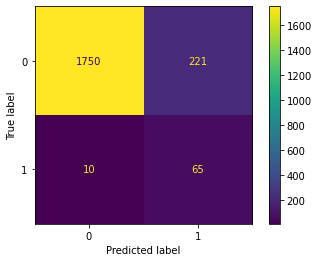

In [360]:
conf_mat = confusion_matrix(y_test, logY_pred)
print('AUC Score', roc_auc_score(y_test, logY_pred))

plot_confusion_matrix(log_model, x_test, y_test)
plt.show()

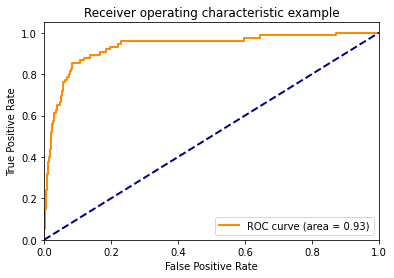

In [361]:
y_pred_proba = log_model.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.show()

# Decision Tree--------------------------------------------------------------------

The Decision tree was a bit more challenging than the logistic regression model. Trying to work out the best hyperparameters was difficult at times, but ccp_alpha of about .01 ended up giving the best result. Other parameters were interesting to mess around with but were not very fruitful.

0.8776255707762557


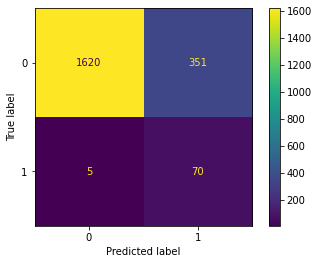

In [362]:
dTree = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.01)
dTree.fit(x_trainSM, y_trainSM)
dTreeY_pred = dTree.predict(x_test)

print(roc_auc_score(y_test, dTreeY_pred))

plot_confusion_matrix(dTree, x_test, y_test)
plt.show()

In [364]:
path=dTree.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas = path.ccp_alphas
print(ccp_alphas)


[0.         0.00041902 0.00057718 0.00057718 0.00057718 0.00057718
 0.00057718 0.00067989 0.00068866 0.00075626 0.00075626 0.00075626
 0.0007826  0.00086774 0.00086774 0.00087306 0.00091107 0.00091983
 0.00099927 0.00101288 0.00103718 0.00103923 0.00104039 0.00104346
 0.00111252 0.00112145 0.00116585 0.00118156 0.00119769 0.00120096
 0.00120318 0.00121315 0.00124333 0.00124333 0.00126338 0.00126584
 0.00126584 0.00126908 0.00134636 0.00135601 0.00140116 0.00144716
 0.00146033 0.00150799 0.00153092 0.00153294 0.00153605 0.00156466
 0.00159972 0.00166278 0.00174307 0.00178644 0.00185939 0.00190999
 0.00203427 0.00218252 0.0021957  0.00222686 0.00223668 0.00236849
 0.00347706 0.00351614 0.00381197 0.00558877 0.00840124 0.01459839
 0.03960638]


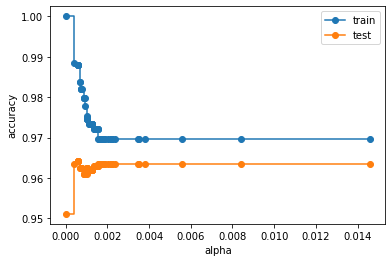

In [365]:
ccp_alphas = ccp_alphas[:-1]
dTree_Palphas = []
for alpha in ccp_alphas:
    dTree3 = DecisionTreeClassifier(ccp_alpha=alpha, random_state=100)
    dTree3.fit(x_train, y_train)
    dTree_Palphas.append(dTree3)
train_scores = [dTree3.score(x_train, y_train) for dTree3 in dTree_Palphas]
test_scores = [dTree3.score(x_test, y_test) for dTree3 in dTree_Palphas]

fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
ax.legend()
plt.show()

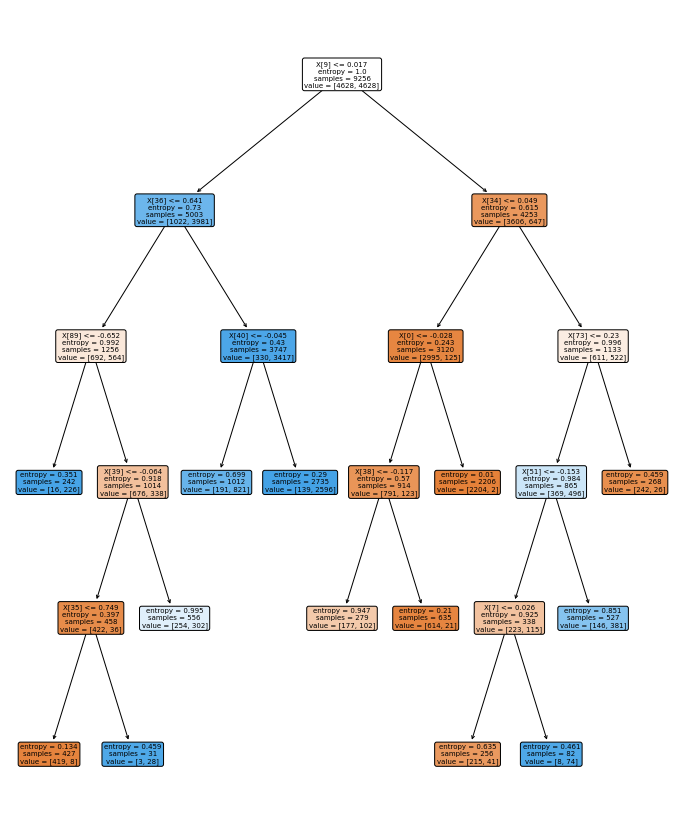

In [366]:
fig, ax = plt.subplots(figsize=(12, 15))
tree.plot_tree(dTree2, filled=True, rounded=True, fontsize=7);

# XGBoost---------------------------------------------------------------------------

I worked on XGBoost for quite a bit and used RandomSearchCV to get good parameters for the model. Although RandomSearchCV did help quite a bit, some of its values were not amazing. I was able to get a better AUC score by messing with the parameters some more. The first chunk below shows the parameters I used for the RandomSearchCV.

In [367]:
# param_grid = {
#         'silent': [False],
#         'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
#         'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
#         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#         'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#         'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#         'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
#         'gamma': [0, 0.25, 0.5, 1.0],
#         'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
#         'n_estimators': [100],
#         'tree_method':['gpu_hist'],
#         'use_label_encoder':[False], 
#         'eval_metric':['auc']}
# classifier=xgb.XGBClassifier()
# random_search=RandomizedSearchCV(classifier,param_distributions=param_grid,n_iter=20,scoring='roc_auc',n_jobs=1,cv=2,verbose=2, refit=True)
# random_search.fit(x_trainSM,y_trainSM)

# print(random_search.best_estimator_)


0.8892237442922373


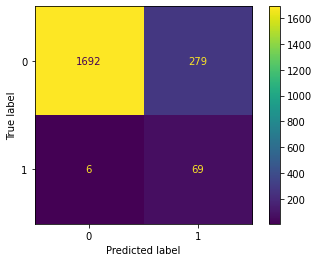

<Figure size 14400x14400 with 0 Axes>

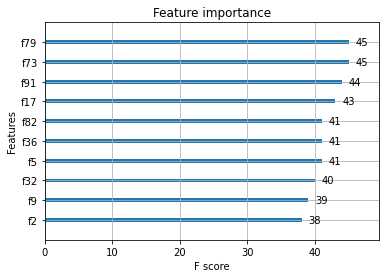

In [368]:
boost=xgb.XGBClassifier(booster='gbtree',
              colsample_bytree=0.3,colsample_bynode=.1, gamma=0.3, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=5,missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=15, reg_lambda=30, scale_pos_weight=10, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None, use_label_encoder=False, eval_metric='auc')

boost.fit(x_trainSM, y_trainSM)
boost_pred = boost.predict(x_test)

print(roc_auc_score(y_test, boost_pred))
plot_confusion_matrix(boost, x_test, y_test)

plt.figure(figsize=(200,200))
xgb.plot_importance(boost, max_num_features=10)
plt.show()

# Neural Networks-------------------------------------------------------------------

It was a lot of fun learning Keras, but I'm not sure if I can say that about PyTorch though. But regardless of that, I experimented with various parameters, number of layers, number of nodes per layer, as well as different activation and optimization functions for Keras and PyTorch. I got a much better result with Keras. And Keras yielded the highest AUC score of all the models used for this project.

### Keras

In [370]:
Knet = Sequential()
Knet.add(Dense(45, input_shape=(95,), activation='tanh'))

Knet.add(Dense(1, activation='sigmoid'))

Knet.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['AUC', 'TrueNegatives', 'FalsePositives','FalseNegatives','TruePositives'])

Knet.fit(x_trainSM, y_trainSM, epochs=20)

Knet.summary()

Epoch 1/20
290/290 [==============================] - 2s 955us/step - loss: 0.5172 - auc: 0.8493 - true_negatives: 1375.9553 - false_positives: 940.2749 - false_negatives: 150.5086 - true_positives: 2204.9863
Epoch 2/20
290/290 [==============================] - 0s 956us/step - loss: 0.3802 - auc: 0.9294 - true_negatives: 1778.9313 - false_positives: 550.2199 - false_negatives: 159.6598 - true_positives: 2182.9141
Epoch 3/20
290/290 [==============================] - 0s 906us/step - loss: 0.3279 - auc: 0.9430 - true_negatives: 1902.7079 - false_positives: 431.0034 - false_negatives: 185.3024 - true_positives: 2152.7113
Epoch 4/20
290/290 [==============================] - 0s 983us/step - loss: 0.3061 - auc: 0.9482 - true_negatives: 1951.6907 - false_positives: 392.7113 - false_negatives: 187.4708 - true_positives: 2139.8522
Epoch 5/20
290/290 [==============================] - 0s 939us/step - loss: 0.2851 - auc: 0.9543 - true_negatives: 1961.5808 - false_positives: 368.4124 - false_neg

64/64 [==============================] - 1s 884us/step - loss: 0.2683 - auc: 0.9279 - true_negatives: 1753.0000 - false_positives: 218.0000 - false_negatives: 11.0000 - true_positives: 64.0000
AUC Score 0.9279452562332153
True Negative acurracy 0.8893962455606291
True Positive acurracy 0.8533333333333334


Text(42.0, 0.5, 'Truth')

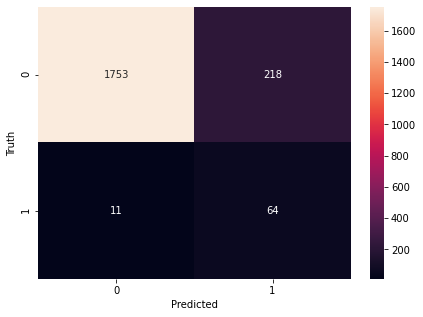

In [371]:
kPred=Knet.predict(x_test)
loss, AUC, TN,FP,FN , TP=Knet.evaluate(x_test, y_test)

print('AUC Score', AUC)
TNacc = TN/(TN+FP)
TPacc = TP/(TP+FN)
print('True Negative acurracy',TNacc)
print('True Positive acurracy',TPacc)
cm=[[int(TN), int(FP)],[int(FN), int(TP)]]
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### PyTorch

In [372]:

x_trainSM = torch.from_numpy(x_trainSM)
y_trainSM = torch.tensor(y_trainSM)
x_test = torch.from_numpy(x_test)
y_test = torch.tensor(y_test)



x_trainSM = x_trainSM.float()
y_trainSM = y_trainSM.float()
x_test = x_test.float()
y_test = y_test.float()

In [373]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(95, 45)
        
        self.layer2 = nn.Linear(45, 1)

    def forward(self, x):
        x= torch.tanh(self.layer1(x))
        
        x= torch.relu(self.layer2(x))

        return torch.sigmoid(x)

net = Net()
optimizer = optim.Adam(net.parameters(),lr=.0001)


def calc_acc(y_true, y_pred):
    pred_val = y_pred.ge(.5).view(-1)
    return (y_true == pred_val).sum().float()/len(y_true)

In [374]:
criterion = nn.BCELoss()
epochs = 20
with torch.no_grad():
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_predPT = net(x_trainSM)
        y_predPT = torch.squeeze(y_predPT)

        train_loss = criterion(y_predPT, y_trainSM)
        optimizer.step()
        if epoch % 100 == 0:
            train_acc = calc_acc(y_trainSM, y_predPT)
print(train_acc)

tensor(0.5000)


In [375]:

for epoch in range(epochs):
    y_test_PD = net(x_test)
    
    y_test_PD = torch.squeeze(y_test_PD)

    test_loss = criterion(y_test_PD, y_test)

    optimizer.step()
    if epoch % 100 == 0:
        test_acc = calc_acc(y_test, y_test_PD)
print(test_acc)

tensor(0.0367)


# Conclusion

There were quite a few roadblocks that were present when trying to make models for this dataset. The biggest of these problems was the huge imbalance in data. Only about 3% of the companies described in the data went bankrupt. So out of the 6800 values in the Bankruptcy column, only about 200 were 1's while the rest were 0's. The final solution I came to was using the SMOTE package to create fake data to offset the imbalance. The next problem was the lack of correlation between the Bankruptcy and any of the other variables. The highest positive correlation was .25 while the lowest negative correlation was -.31. This was a huge hindrance for all of the models. It would have been better if there were variables that had insight on the employees of the companies as well. For example, education levels, employee turnover rate, age, etc. Variables like those are also key indicators of the health of a company, but were not present in the dataset.

Regardless of all of the roadblocks, the models did fairly well except PyTorch. Scikit learn's Logistic Regression had an AUC score of about .887, Decision Tree had an AUC score of about .877, XGBoost with an AUC of .889, Keras had the highest AUC score of about .927 and PyTorch was the worst. The Area Under the Curve metric was used due to the heavy imbalance of the test dataset. If a normal accuracy score was in place, it would almost always have a score beyond .95. This is because the models would guess 'not bankrupt' most of the time and cause the score to be artificially high. The AUC score gave a better insight into the ability of the models to distinguish between the positive and negative possibilities. 1 or 'yes bankrupt' was the positive and 0 or 'not bankrupt' would be the negative. I tried my best to get an AUC score of at least .8 in all of the models, but I gave up on PyTorch since I couldn't get it to work.

Regarding PyTorch, I could not get it to properly work and I just don't know why. I spent about 2 days on PyTorch alone and watched multiple tutorials but it did not give a proper score and did not seem to train properly either. The way I had to impute the data resulted in some issues with PyTorch that I kind of solved, but solving it gave other issues. I will try to improve the score and my knowledge of PyTorch after submitting the project to see if I can figure it out.